In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from collections import deque
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class Network(nn.Module):
    def __init__(self, state_space, action_space, seed):
        super(Network, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(state_space, 16),
            nn.ReLU(),
#             nn.Linear(64, 64),
#             nn.ReLU(),
            nn.Linear(16, action_space)
        )

    def forward(self, x):
        return F.softmax(self.model(torch.tensor(x).float()))
    
    
    def act(self, x):
        x = torch.from_numpy(x).float().to(device)
        # https://pytorch.org/docs/stable/distributions.html#score-function
        probabilities = self.forward(x)
        m = Categorical(probabilities)
        action = m.sample()
        log = m.log_prob(action)
        
        return action, log

In [5]:
import gym
env = gym.make("CartPole-v1")

state_space = env.observation_space.shape[0]
action_space =env.action_space.n

In [13]:
max_episodes = 2000
max_t = 500
update_every = 4
gamma = 0.99
win_condition = 200

In [14]:
def update_model():
    discounts = [gamma ** i for i in range(len(reward_log)+1)]    
    rewards = [discount * reward for (discount, reward) in zip(discounts, reward_log)]
    G = np.array(rewards).sum()
    
    policy_loss = np.array([ -log * G for log in policy_log]).sum()
    
    optimiser.zero_grad()
    policy_loss.backward()
    optimiser.step()

In [19]:
model = Network(state_space, action_space, 1234).to(device)
optimiser = optim.Adam(model.parameters(),lr=1e-2)

scores_deque = deque(maxlen=100)

score_log = []
average_score_log = []

for episode in range(max_episodes):
    state = env.reset()
    
    policy_log = []
    reward_log = []
    
    for t in range(max_t):
        action, log = model.act(state)
        state, reward, done, info = env.step(action.cpu().item())
        
        reward_log.append(reward)
        policy_log.append(log)
        
        if done:
            break
        
    update_model()
    
    scores_deque.append(np.array(reward_log).sum())
    
    # Book Keeping
    score_log.append(np.array(reward_log).sum())
    average_score_log.append(np.array(scores_deque).mean())
    
        
    print("\r Episode: {:.1f}\tAverage Score {:.2f}\tReward: {:.2f}".format(episode, np.mean(average_score_log), np.array(scores_deque).mean()), end="")
    if (episode % 100 == 0):
        print("\r Episode: {:.1f}\tAverage Score {:.2f}\tReward: {:.2f}".format(episode, np.mean(average_score_log), np.array(scores_deque).mean()))

    if np.mean(scores_deque) > win_condition:
        print("\rEnvironment Solved!")
        break

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


 Episode: 0.0	Average Score 17.00	Reward: 17.00
 Episode: 100.0	Average Score 28.02	Reward: 37.15
 Episode: 200.0	Average Score 37.74	Reward: 47.84
 Episode: 300.0	Average Score 41.28	Reward: 57.15
 Episode: 400.0	Average Score 46.26	Reward: 58.41
 Episode: 500.0	Average Score 50.47	Reward: 70.91
 Episode: 600.0	Average Score 54.68	Reward: 97.73
 Episode: 700.0	Average Score 69.59	Reward: 196.80
 Episode: 718.0	Average Score 72.77	Reward: 200.11Environment Solved!


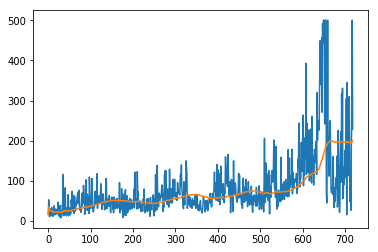

In [20]:
plt.plot(score_log)
plt.plot(average_score_log)

In [ ]:
for episode in range(3):
    state = env.reset()
    score = 0
    input()

    for t in range(max_t):
        action = actor.act(state, add_noise=False)
        next_state, reward, done, _ = env.step(action)
        env.render()
        
        score += reward
        
        if done:
            print(score)
            break;

env.close()